In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from utils import *


In [6]:
class State():
    def __init__(self, u):
        self.u = u
        self.t = 0
        self.m_rb = 18.88 # [kg]
        self.m_tot = self.m_rb + mass(self.t)
        self.roll = 0
        self.com = np.array([0,0,0])
    
    def _update_time_dependent_variables(self, dt):
        self.t = self.t + dt
        self.m_tot = self.m_rb + mass(self.t)
    
    def update_state(self, dt, forces=np.zeros(3),roll_torque=0):
        self._update_time_dependent_variables(dt)
        pos = self.u[:3]
        vel = self.u[3:6]
        acc = self.u[6:9]
        es = self.u[9:13]

        # In ref frame of rocket
        # w = self.u[13:]
        
        
        # decide if rocket is still on rail
        if np.linalg.norm(pos) < 3:
            #position changes in one degree of freedom
            pos += np.dot(np.array([0,0,1]), vel) * dt
        else:
            pos += vel * dt

        # update roll
        self.roll += roll_torque * dt
        
        
        # Current Orientation of Rocket -- Quaternion (w, i, j, k)
        q = np.array([e0, e1, e2, e3])

        # update quaternion to match linear velocity
         
        ang = 2*np.arccos(e0)

        sin_ang = np.sin(ang/2)**2
        q_prime = np.array([np.cos(ang/2)**2,vx*sin_ang * dt, vy*sin_ang * dt, vz*sin_ang * dt])
        qdot = q_prime - q

        #normalize qdot
        qdot = qdot / np.linalg.norm(qdot)

        # update angular velocity based on qdot
        omega_matrix = 2 * np.array([
                        [-e1, e0, e3, -e2],
                        [-e2, -e3, e0, e1],
                        [-e3, e2, -e1, e0]
                    ])
        w = omega_matrix @ qdot
        w += np.array([0,0,self.roll])
        
        vel += acc * dt + np.cross(w, self.com) * dt
        acc = forces / self.m_tot * dt + np.cross(w,np.cross(w,self.com)) * dt
        
        # update u
        self.u = np.array([*pos, *vel, *acc, *q, *w])


In [3]:
class Sensor_State():
    def __init__(self, u, sensor_offset):
        self.u = u
        self.sensor_offset = sensor_offset

    
    def update_state(self, dt, rocket_state):
        q = rocket_state.u[9:13]
        omega = rocket_state.u[13:16]
        
        # perform a quaternion rotation on location of sensor
        local_sensor_offset = rot_by_q(q,np.array([0.5,0,2]))
        
        self.u = rocket_state.u
        
        self.u[0:3] += local_sensor_offset
        self.u[3:6] += np.cross(omega, local_sensor_offset)
        self.u[6:9] += np.cross(omega, np.cross(omega, local_sensor_offset))


In [4]:

# quaternion initial conditions at 2 degrees
initial_angle = 5 * np.pi / 180

initial_q = np.array([np.cos(initial_angle / 2), 0, np.sin(initial_angle / 2), np.sin(initial_angle / 2)])

u = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])

state = State(u)

sensor_offset = np.array([0,-0.2,-0.5]) # location of the sensor relative to the tip
sensor_u = np.array([0,0,0, 0, 0, 0, 0, 0, 0,*initial_q,0,0,0])
sensor_state = Sensor_State(sensor_u, sensor_offset)

total_time = 40
dt = 0.01

times = np.arange(0, total_time, dt)
states = []
sensor_states = []
thrusts = []
drags = []
total_forces = []




masses = []
for i in range(len(times)):
    if state.u[2] < 0 and i > 20:
        break
    ## calculate forces ##
    
    relative_wind = (wind_vector(*state.u[:3]) - state.u[3:6])
    
    # calculate drag force
    if state.u[5] < 0:
        drag = calculate_drag(
        velocity = state.u[3:6],
        air_density = calculate_air_density(state.u[2]),
        C_d = 2.2,
        A_s = 2.63)
        drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
        wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (2.63)
        
    else:
        drag = calculate_drag(
        velocity = state.u[3:6],
        air_density = calculate_air_density(state.u[2]),
        C_d = 0.37,
        A_s = 0.066)
        drag_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else -drag * state.u[3:6] / np.linalg.norm(state.u[3:6])
        wind = relative_wind.dot(relative_wind) * calculate_air_density(state.u[2]) * (0.066)

    # multiply by normalized velocity vector
                            #np.zeros(3))
    drags.append(drag_force[2])
    # calculate thrust force
    thrust = f_thrust(state.t)
    thrusts.append(thrust)
    heading_vector = np.array([0,0,1]) if np.linalg.norm(state.u[3:6]) < 1e-1 else state.u[3:6] / np.linalg.norm(state.u[3:6])
    thrust_force = heading_vector * thrust
    
    # calculate gravity force
    gravity = np.array([0, 0, -9.81]) * state.m_tot
    masses.append(state.m_tot)
    
    wind_force = np.zeros(3) if np.linalg.norm(state.u[3:6]) < 1e-5 else wind * relative_wind / np.linalg.norm(relative_wind)
    
    total_force = drag_force + thrust_force + gravity + 1 * wind_force
    total_forces.append(total_force[2])
    
    
    roll_torque = 1 * state.u[5]
    
    
    state.update_state(dt, forces = total_force, roll_torque = roll_torque)    
    states.append(state.u)

    sensor_state.update_state(dt, state)
    sensor_states.append(sensor_state.u)


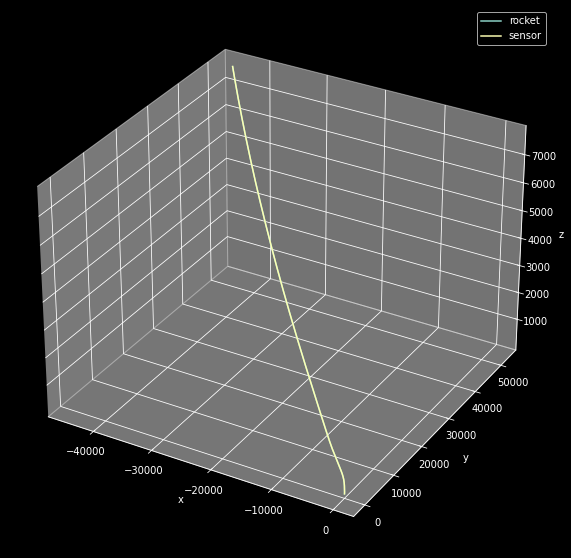

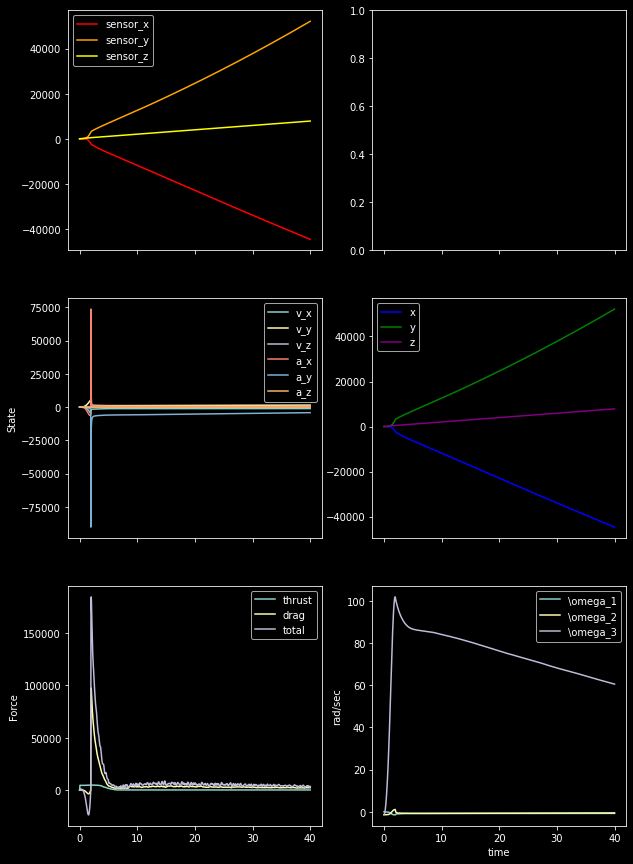

4000


In [5]:
# plotting results
fig1 = plt.figure(figsize=(10, 10))
position = fig1.add_subplot(111, projection='3d')
position.plot([state[0] for state in states], [state[1] for state in states], [state[2] for state in states],label='rocket')
position.plot([s_state[0] for s_state in sensor_states], [s_state[1] for s_state in sensor_states], [s_state[2] for s_state in sensor_states],label='sensor')
position.set_xlabel('x')
position.set_ylabel('y')
position.set_zlabel('z')
plt.legend()
plt.show()

# Second Plot: Subplots sharing the same x-axis
fig2, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(3, 2, figsize=(10, 15), sharex=True)

# Subplot 1: x,y,z states over time
ax0.plot(times, [s_state[0] for s_state in sensor_states], label='sensor_x', color='red')
ax0.plot(times, [s_state[1] for s_state in sensor_states], label='sensor_y', color='orange')
ax0.plot(times, [s_state[2] for s_state in sensor_states], label='sensor_z', color= 'yellow')
ax0.legend()



ax3.plot(times, [state[0] for state in states], label='x', color = 'blue')
ax3.plot(times, [state[1] for state in states], label='y', color = 'green')
ax3.plot(times, [state[2] for state in states], label='z', color = 'purple')
ax3.legend()

ax2.plot(times, [state[3] for state in states], label='v_x')
ax2.plot(times, [state[4] for state in states], label='v_y')
ax2.plot(times, [state[5] for state in states], label='v_z')
ax2.plot(times, [state[6] for state in states], label='a_x')
ax2.plot(times, [state[7] for state in states], label='a_y')
ax2.plot(times, [state[8] for state in states], label='a_z')
ax2.legend()
ax2.set_ylabel('State')

# Subplot 2: x,y,z acceleration over time
ax4.plot(times, thrusts, label="thrust")
ax4.plot(times, drags, label="drag")
ax4.plot(times, total_forces, label="total")
ax4.set_ylabel('Force')
ax4.legend()

# Subplot 3: omega1, omega2, omega3 over time
ax5.plot(times, [state[13] for state in states], label='\\omega_1')
ax5.plot(times, [state[14] for state in states], label='\\omega_2')
ax5.plot(times, [state[15] for state in states], label='\\omega_3')
ax5.set_xlabel('time')
ax5.set_ylabel('rad/sec')
ax5.legend()

plt.show()
print(len(sensor_states))
